# multilayer SNN, no learning rule yet
## importing neuron classes
### trying to get waves in both retina and lgn layers, WTA still there

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import pdist, squareform
from IPython.display import clear_output
%matplotlib inline
from nengo.utils.matplotlib import rasterplot

import nengo
from nengo.params import Parameter, NumberParam, NdarrayParam
from nengo.neurons import settled_firingrate  
from nengo.neurons import LIFRate, NeuronType

In [2]:
from L1_Neuron import CustomLIF
from L2_Neuron import LGNLIF

In [3]:
def plot_probes(sim, voltage_probe, threshold_probe, spikes_probe):
    plt.figure(figsize=(12, 6))
    plt.subplot(131)
    plt.plot(sim.trange(), sim.data[voltage_probe])
    #plt.plot(sim.trange(), sim.data[threshold_probe], label = 'threshold')
    plt.xlabel('time [s]')
    plt.ylabel('a voltage')
    #plt.legend()
    
    plt.subplot(132)
    plt.plot(sim.trange(), sim.data[threshold_probe])
    plt.xlabel('time [s]')
    plt.ylabel('a threshold voltage')
    
    plt.subplot(133)
    rasterplot(sim.trange(), sim.data[spikes_probe])
    plt.xlabel('time [s]')
    plt.ylabel('Neuron number (a spikes)')

In [4]:
nR = 1600
nL = 512

In [5]:
weights = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]])
# np.random.randn(3,3)
W1 = np.random.normal(2.5, .14, (nR,nL))
W1 = W1/np.mean(W1, axis = 0) * 2.5    # Weight Matrix between Retina-LGN1 normrnd initialized take column mean
W1 = W1.T

In [6]:
# need to make Ss, nR, tau_v, piT_th, piTV_plus, piV_th,piV_reset,nxs, Vt for a

# need to make Ss, nL, tau_v, piT_th, piTV_plus, piV_th, piV_reset, nxs, Vt, S_x, and thresh for b.
# try to do this in a better way 

# maybe a function that returns a dictionary of the values needed and calculates them?

def l1_params(num, sq, ri, ro, lam, ai, ao, tau_v, tau_th, th_plus, v_th):
    params = {}
    v_reset = 0+0.1*(np.random.randn(num,))**2 # Noise on activity field
    # Spatial Parameters

    nx = sq*np.random.rand(num,2)

    # Dynamics parameters

    # Nondimensional parameters
    Vt, Tt, Lt = ao, tau_v, sq

    # Nondimensional groups
    piTV_plus = th_plus * Tt / Vt
    piT_th = Tt / tau_th 

    piV_th = v_th / Vt
    piV_reset = v_reset / Vt;
    piV_ai = ai / Vt

    piL_ri = ri / Lt
    piL_ro =  ro / Lt
    piL_lam = lam / Lt
    
    # Non-dimensional Spatial Adjacency matrix
    nxs = nx / Lt;
    Ds = squareform(pdist(nxs))     # Non-dimensional distance matrix
    Ss = piV_ai *(Ds < piL_ri) - (Ds > piL_ro) * np.exp(-Ds / piL_lam); 
    Ss = Ss - np.diag(np.diag(Ss));      # Adjacency matrix between Neurons in Retina
    
    params["Ss"] = Ss
    params["num"] = num
    params["tau_rc"] = tau_v
    params["piT_th"] = piT_th
    params["piTV_plus"] = piTV_plus
    params["piV_th"] = piV_th
    params["piV_reset"] = piV_reset
    params["nxs"] = nxs
    params["Vt"] = Vt
    return params


In [7]:
# need to make Ss, nR, tau_v, piT_th, piTV_plus, piV_th,piV_reset,nxs, Vt for a

# need to make Ss, nL, tau_v, piT_th, piTV_plus, piV_th, piV_reset, nxs, Vt, S_x, and thresh for b.
# try to do this in a better way 

# maybe a function that returns a dictionary of the values needed and calculates them?

def l2_params(num, sq, ri, ro, lam, ai, ao, tau_v, tau_th, th_plus, v_th, mu_thresh, sigma_thresh):
    params = {}
    v_reset = 0+0.1*(np.random.randn(num,))**2 # Noise on activity field
    # Spatial Parameters

    nx = sq*np.random.rand(num,2)

    # Dynamics parameters

    # Nondimensional parameters
    Vt, Tt, Lt = ao, tau_v, sq

    # Nondimensional groups
    piTV_plus = th_plus * Tt / Vt
    piT_th = Tt / tau_th 

    piV_th = v_th / Vt
    piV_reset = v_reset / Vt;
    piV_ai = ai / Vt

    piL_ri = ri / Lt
    piL_ro =  ro / Lt
    piL_lam = lam / Lt
    
    # Non-dimensional Spatial Adjacency matrix
    nxs = nx / Lt;
    Ds = squareform(pdist(nxs))     # Non-dimensional distance matrix
    Ss = piV_ai *(Ds < piL_ri) - (Ds > piL_ro) * np.exp(-Ds / piL_lam); 
    Ss = Ss - np.diag(np.diag(Ss));      # Adjacency matrix between Neurons in Retina
    
    # non-dimensional LGN layer stuff
    S_x = piV_ai *(Ds < (piL_ri/100)) - (Ds > (piL_ro/100)) * np.exp(-Ds / piL_lam); 
    S_x = S_x - np.diag(np.diag(S_x));      # Adjacency matrix between Neurons 

    thresh = np.random.normal(mu_thresh, sigma_thresh, (nL,))

    
    params["Ss"] = Ss
    params["num"] = num
    params["tau_rc"] = tau_v
    params["piT_th"] = piT_th
    params["piTV_plus"] = piTV_plus
    params["piV_th"] = piV_th
    params["piV_reset"] = piV_reset
    params["nxs"] = nxs
    params["Vt"] = Vt
    params["S_x"] = S_x
    params["thresh"] = thresh
    
    return params


In [8]:
retina = l1_params(num=1600, sq=28, ri=3, ro=6, lam=10, ai=30, ao=10, tau_v=1, tau_th=30, th_plus=9, v_th=1)
lgn = l2_params(num=512, sq=10, ri=1.2, ro=1.5, lam=10, ai=30, ao=10, tau_v=1, tau_th=10, th_plus=6, v_th=1, mu_thresh = 40, sigma_thresh = 2)


In [9]:
1.2/10

0.12

In [31]:
retina["piT_th"]

0.03333333333333333

In [32]:
lgn["piT_th"]

0.1

In [10]:
a = 3*np.random.randn(4,) / 10

In [11]:
(lgn["Ss"] > 0).sum()

10954

In [12]:
(lgn["S_x"] > 0).sum()

0

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

threshold = [3.33333333e-06 3.33333333e-06 3.33333333e-06 ... 3.33333333e-06
 3.33333333e-06 3.33333333e-06]
threshold shape = (1600,)
spiked shape= (1600,)
threshold = [6.66655556e-06 6.66655556e-06 9.03333333e-04 ... 6.66655556e-06
 9.03333333e-04 6.66655556e-06]
threshold shape = (1600,)
spiked shape= (1600,)
threshold = [9.99966667e-06 9.99966667e-06 9.06636556e-04 ... 9.99966667e-06
 9.06636556e-04 9.99966667e-06]
threshold shape = (1600,)
spiked shape= (1600,)
threshold = [1.33326667e-05 1.33326667e-05 9.09939668e-04 ... 9.09999667e-04
 9.09939668e-04 1.33326667e-05]
threshold shape = (1600,)
spiked shape= (1600,)
threshold = [1.66655556e-05 1.66655556e-05 9.13242670e-04 ... 1.80999967e-03
 9.13242670e-04 9.13332667e-04]
threshold shape = (1600,)
spiked shape= (1600,)
threshold = [1.99983334e-05 9.16665556e-04 9.16545562e-04 ... 2.70999967e-03
 9.16545562e-04 1.81333267e-03]
threshold shape = (1600,)
spiked shape= (1600,)
threshold = [2.33310001e-05 1.81666556e-03 9.19848343e-04 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Text(0, 0.5, 'Neuron number (b spikes)')

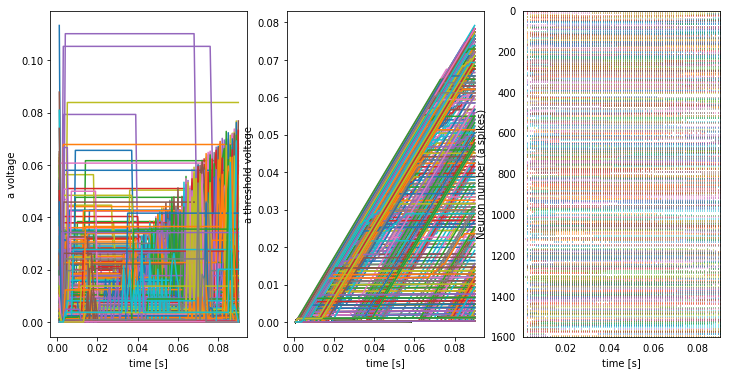

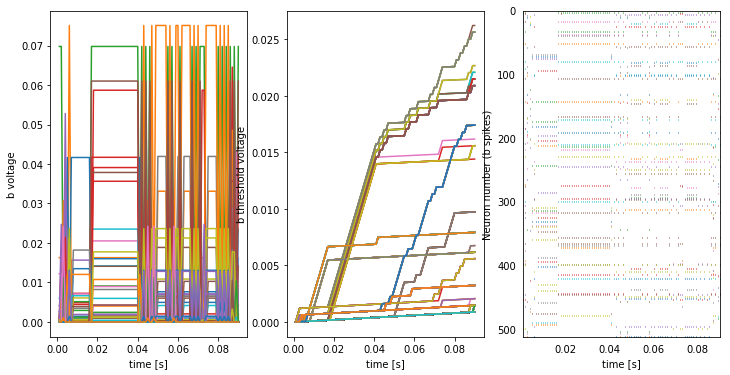

In [13]:


model = nengo.Network(label='2D Representation', seed=10)

with model:
    # node = nengo.Node(np.sin)
    # a = nengo.Ensemble(nR, dimensions=1, neuron_type=CustomLIF(Ss, nR, tau_v, piT_th, piTV_plus, piV_th,
    #                                                            piV_reset,nxs, Vt, wave = True), label = "a")
    
    
#     b = nengo.Ensemble(nL, dimensions=1, neuron_type=LGNLIF(Ss, S_x, nL, tau_v, piT_th, piTV_plus, piV_th,
#                                                              piV_reset,nxs, Vt, thresh, wave=False), label = "b")

    a = nengo.Ensemble(nR, dimensions=1, neuron_type = CustomLIF(*retina.values(), wave=False), label="a")
    b = nengo.Ensemble(nL, dimensions=1, neuron_type = LGNLIF(*lgn.values(), wave=False), label="a")

    conn = nengo.Connection(a.neurons, b.neurons, transform = W1, synapse = None)
    
    spikes_probe = nengo.Probe(a.neurons, 'spikes')
    voltage_probe = nengo.Probe(a.neurons, 'voltage')
    threshold_probe = nengo.Probe(a.neurons, 'threshold')
    
    b_spikes = nengo.Probe(b.neurons, 'spikes')
    b_voltage = nengo.Probe(b.neurons, 'voltage')
    b_threshold = nengo.Probe(b.neurons, 'threshold')
    
    conn_out = nengo.Probe(conn, 'output')
    conn_in = nengo.Probe(conn, 'input')

with nengo.Simulator(model) as sim:
    sim.run(.09)
    
# Plotting Retina

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.plot(sim.trange(), sim.data[voltage_probe])
#plt.plot(sim.trange(), sim.data[threshold_probe], label = 'threshold')
plt.xlabel('time [s]')
plt.ylabel('a voltage')
#plt.legend()

plt.subplot(132)
plt.plot(sim.trange(), sim.data[threshold_probe])
plt.xlabel('time [s]')
plt.ylabel('a threshold voltage')

plt.subplot(133)
rasterplot(sim.trange(), sim.data[spikes_probe])
plt.xlabel('time [s]')
plt.ylabel('Neuron number (a spikes)')
               
# Plotting LGN

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.plot(sim.trange(), sim.data[b_voltage])
#plt.plot(sim.trange(), sim.data[threshold_probe], label = 'threshold')
plt.xlabel('time [s]')
plt.ylabel('b voltage')
#plt.legend()

plt.subplot(132)
plt.plot(sim.trange(), sim.data[b_threshold])
plt.xlabel('time [s]')
plt.ylabel('b threshold voltage')

plt.subplot(133)
rasterplot(sim.trange(), sim.data[b_spikes])
plt.xlabel('time [s]')
plt.ylabel('Neuron number (b spikes)')
                 

In [28]:
lgn["thresh"];

In [35]:
# Visualization of Wave
for t in range(len(sim.trange())):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.scatter(retina["nxs"][:,0], retina["nxs"][:,1], color = 'k')
    plt.title('Ret-Wave step =' + str(t))
    fired = np.argwhere(sim.data[spikes_probe][t,:])
    plt.scatter(retina["nxs"][fired,0], retina["nxs"][fired,1], color = 'r')
    
    plt.subplot(122)
    plt.scatter(lgn["nxs"][:,0], lgn["nxs"][:,1], color = 'k')
    plt.title('LGN-Wave step =' + str(t))
    fired = np.argwhere(sim.data[b_spikes][t,:])
    plt.scatter(lgn["nxs"][fired,0], lgn["nxs"][fired,1], color = 'r')
    plt.show()
    clear_output(wait=True)


KeyboardInterrupt: 

# end of relevant, everything after was used for debugging

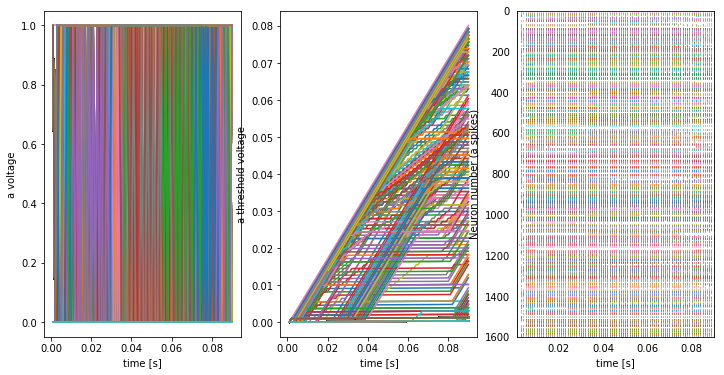

In [30]:
plot_probes(sim, spikes_probe, threshold_probe, spikes_probe)

No handles with labels found to put in legend.


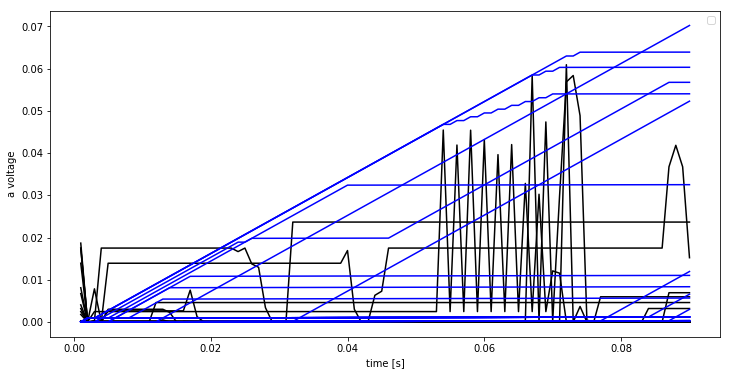

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(sim.trange(), sim.data[voltage_probe][:,:30], c = 'k')
plt.plot(sim.trange(), sim.data[threshold_probe][:,:30], c = 'b')
plt.xlabel('time [s]')
plt.ylabel('a voltage')
plt.legend()

In [15]:
sim.data[conn_in]

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [16]:
np.random.normal(40,2, (5,)).shape

(5,)

In [17]:
(sim.data[spikes_probe][4] ==1).sum()

320

In [18]:
sim.data[spikes_probe].shape

(90, 1600)

In [19]:
sim.data[conn_out]

array([[2011.5433389 , 2005.94943118, 2011.69811555, ..., 2011.7894675 ,
        2007.71786438, 2011.36266932],
       [   2.36038145,    2.79546216,    2.29999125, ...,    2.66468706,
           2.76461567,    2.56649286],
       [ 690.45547336,  695.32392649,  693.3437511 , ...,  696.13801212,
         696.3689257 ,  694.529189  ],
       ...,
       [ 796.85237144,  793.43954239,  794.21223204, ...,  795.45888366,
         795.44758726,  793.82402396],
       [ 772.60355067,  770.15326542,  771.03416933, ...,  773.27090024,
         773.27144779,  771.22332344],
       [ 748.403532  ,  746.08976764,  746.51601564, ...,  748.81106741,
         747.68826326,  746.71590755]])

In [20]:
sim.data[b_threshold]

array([[1.00000000e-05, 1.00000000e-05, 1.00000000e-05, ...,
        1.00000000e-05, 1.00000000e-05, 1.00000000e-05],
       [1.99990000e-05, 1.99990000e-05, 1.99990000e-05, ...,
        1.99990000e-05, 1.99990000e-05, 1.99990000e-05],
       [2.99970001e-05, 2.99970001e-05, 2.99970001e-05, ...,
        2.99970001e-05, 2.99970001e-05, 2.99970001e-05],
       ...,
       [1.46130994e-03, 1.46130994e-03, 1.46125044e-03, ...,
        8.76182950e-04, 8.76182950e-04, 8.76182950e-04],
       [1.47116381e-03, 1.47116381e-03, 1.47110431e-03, ...,
        8.86095332e-04, 8.86095332e-04, 8.86095332e-04],
       [1.48101669e-03, 1.48101669e-03, 1.48095720e-03, ...,
        8.96006722e-04, 8.96006722e-04, 8.96006722e-04]])

In [21]:
sim.data[voltage_probe]

array([[0.00339557, 0.03218928, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02950839, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.02950839, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02950839, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02950839, 0.        ,
        0.        ]])

Text(0, 0.5, 'Neuron number (b spikes)')

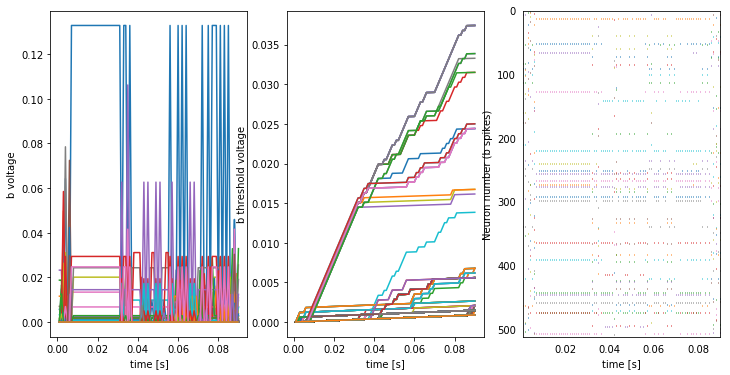

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.plot(sim.trange(), sim.data[b_voltage])
#plt.plot(sim.trange(), sim.data[threshold_probe], label = 'threshold')
plt.xlabel('time [s]')
plt.ylabel('b voltage')
#plt.legend()

plt.subplot(132)
plt.plot(sim.trange(), sim.data[b_threshold])
plt.xlabel('time [s]')
plt.ylabel('b threshold voltage')

plt.subplot(133)
rasterplot(sim.trange(), sim.data[b_spikes])
plt.xlabel('time [s]')
plt.ylabel('Neuron number (b spikes)')

# scratch paper

In [23]:
p = np.array([[3], [4], [5]])

In [24]:
q = np.array([3, 4,5])

In [25]:
q.shape

(3,)

In [26]:
p.shape

(3, 1)

In [27]:
np.matmul(Ss,p)

NameError: name 'Ss' is not defined

In [ ]:
np.matmul(q, Ss)

In [ ]:
np.matmul(Ss,q)

In [ ]:
class Hi:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
nora = Hi(1, 2, 3)
        
    

In [ ]:
nora.c

In [ ]:
sample = {"a" : 3,
          "n" : 7,
         "c" : 4
         }

In [ ]:
sabrine = Hi(*sample.values())

In [ ]:
sabrine.a

In [ ]:
W1.shape

In [ ]:
sim.data[spikes_probe].shape

In [ ]:
(sim.data[spikes_probe][6] == 1).sum()

In [ ]:
x = []; y = [];
for t in range(60):
    x.append(t)
    y.append((sim.data[spikes_probe][t] == 1).sum())
plt.plot(x, y)
plt.ylabel("number of fired neurons")
plt.xlabel("time")
plt.title("number of fired neurons")

    

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.plot(sim.trange(), sim.data[voltage_probe][:,:30])
#plt.plot(sim.trange(), sim.data[threshold_probe], label = 'threshold')
plt.xlabel('time [s]')
plt.ylabel('a voltage')
#plt.legend()

plt.subplot(132)
plt.plot(sim.trange(), sim.data[threshold_probe][:,:30])
plt.xlabel('time [s]')
plt.ylabel('a threshold voltage')

plt.subplot(133)
rasterplot(sim.trange(), sim.data[spikes_probe][:,:30])
plt.xlabel('time [s]')
plt.ylabel('Neuron number (a spikes)')

In [ ]:
sim.data[spikes_probe].shape

In [ ]:
sim.data[spikes_probe][:,:30].shape

In [ ]:
range(60)

In [ ]:
sim.trange().shape

In [ ]:
sim.data[spikes_probe].shape

In [ ]:
sim.data[spikes_probe][1,:].shape

In [ ]:
np.argwhere(sim.data[spikes_probe][1,:])

In [ ]:
fired = np.argwhere(sim.data[spikes_probe][1,:])
plt.scatter(retina["nxs"][fired,0], retina["nxs"][fired,1], color = 'r')


In [49]:
a = np.array([
    [1,2, 3],
    [4, 5, 6],
    [6, 7, 8]
])


    


In [50]:
b = np.array([
    [2, 2, 2],
    [2, 2, 2],
    [2, 2, 2]
])

In [51]:
a * b

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [12, 14, 16]])

In [52]:
a.shape

(3, 3)

In [53]:
np.multiply(a,b)

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [12, 14, 16]])

In [54]:
np.matmul(a,b)

array([[12, 12, 12],
       [30, 30, 30],
       [42, 42, 42]])

In [17]:
sim.data[spikes_probe][10,:] * (2 * np.ones(1600,))

array([0., 2., 0., ..., 2., 0., 2.])

In [22]:
sim.data[threshold_probe][10,:]* (2 * np.ones(1600,))

array([7.33211123e-05, 1.08333311e-02, 1.86611674e-03, ...,
       1.44199993e-02, 1.86611674e-03, 1.26266653e-02])

In [23]:
sim.data[threshold_probe][10,:]

array([3.66605562e-05, 5.41666556e-03, 9.33058370e-04, ...,
       7.20999967e-03, 9.33058370e-04, 6.31333267e-03])

In [26]:
a = np.array([1, 2,3,4,5,])

In [27]:
b = np.array([6, 3,2,1,0,])

In [28]:
a * b

array([6, 6, 6, 4, 0])

In [29]:
type(a)

numpy.ndarray

In [30]:
a.shape

(5,)